In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
version = 3 # just 3 is available
ds = tfds.load(f'speech_commands:0.0.{version}')
train = ds['train']

2024-06-25 17:23:26.912551: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-06-25 17:23:26.912574: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-06-25 17:23:26.912579: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-06-25 17:23:26.912595: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-25 17:23:26.912606: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [103]:
print(train)

<_PrefetchDataset element_spec={'audio': TensorSpec(shape=(None,), dtype=tf.int16, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [24]:
for example in train.take(1):
    print(example)

{'audio': <tf.Tensor: shape=(16000,), dtype=int16, numpy=array([-15, -18, -12, ...,  16,  21,  25], dtype=int16)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=4>}


2024-06-25 17:45:37.516155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [105]:
from collections import Counter


def plot_label_distribution(dataset):
    # Step 1: Extract labels from the dataset
    labels = [element['label'].numpy() for element in dataset]

    # Step 2: Count the occurrences of each label
    label_counts = Counter(labels)

    # Get the labels and their counts
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    # Step 3: Create a pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Instances in the Dataset')
    plt.show()

2024-06-27 12:00:53.133455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


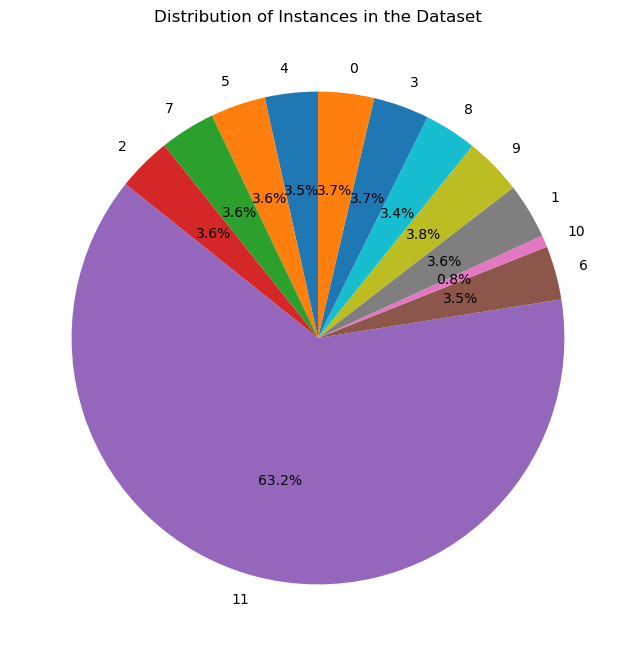

In [106]:
plot_label_distribution(train)

In [62]:
def select_one_tensor_per_category(tensor_list):
    """
    Select one tensor from each category (label).
    
    Args:
    tensor_list (list of dict): A list where each element is a dictionary 
                                containing 'audio' and 'label' keys.
    
    Returns:
    list of dict: A list of selected tensors, one from each category.
    """
    category_dict = {}
    
    for item in tensor_list:
        audio = item['audio'] 
        label = item['label'].numpy()  # Convert to numpy for easier handling
        
        if label not in category_dict:
            category_dict[label] = audio
            
    selected_tensors = [{'audio': audio, 'label':tf.convert_to_tensor(label)} 
                        for label, audio in category_dict.items()]
    
    return selected_tensors


In [63]:
categorial_tensors = select_one_tensor_per_category(train)

2024-06-25 18:25:23.979911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [64]:
print(len(categorial_tensors))

12


In [65]:
from matplotlib import pyplot as plt


def plot_signals_time(titles, signals):
    nrows, ncols = 2, 6
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 6))

    z = 0
    for i in range(nrows):
        for y in range(ncols):
            ax[i, y].set_title(titles[z])
            ax[i, y].plot(signals[z])
            ax[i, y].set_xticks([])
            ax[i, y].set_yticks([])
            ax[i, y].grid(False)
            z += 1

    plt.show()

In [66]:
#sort categorial_tensors by label
categorial_tensors = sorted(categorial_tensors, key=lambda x: x['label'].numpy())

In [67]:
#get the labels,indexes from the dataset builder
info = tfds.builder(f'speech_commands:0.0.{version}').info
labels = info.features['label'].names
labels_index = info.features['label'].num_classes

In [68]:
#convert the labels to text
categorial_audio = [{'audio': item['audio'].numpy(), 'label':f'{i} ' + labels[item['label'].numpy()]} for i,item in enumerate(categorial_tensors)]

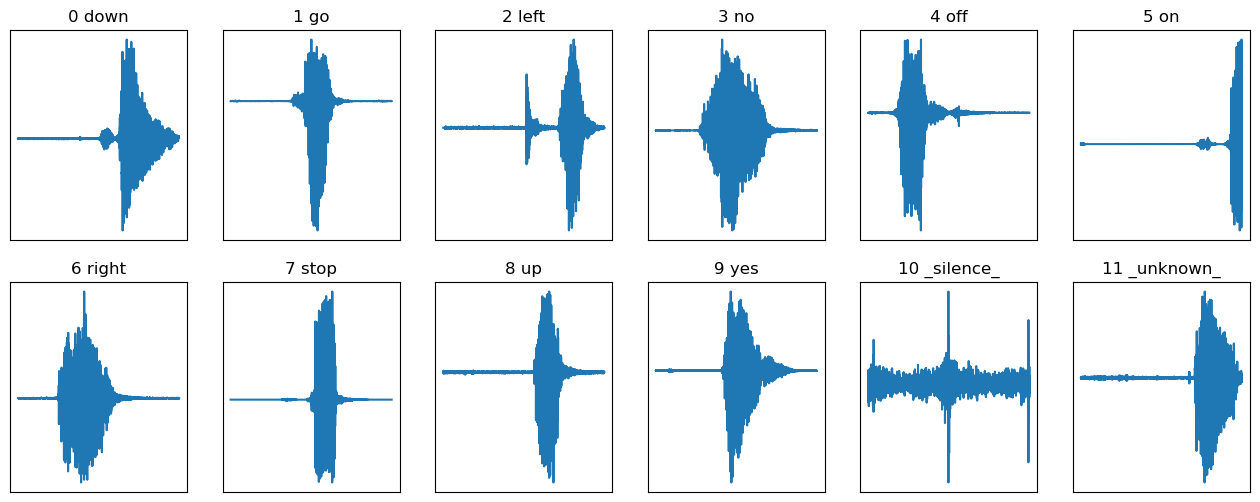

In [69]:
titles = [f'{item["label"]}' for item in categorial_audio]
signals = [item['audio'] for item in categorial_audio]
plot_signals_time(titles, signals)

In [71]:
#check that audio match the label
import IPython.display as ipd
for item in categorial_audio:
    print(item['label'])
    ipd.display(ipd.Audio(item['audio'], rate=16000))

0 down


1 go


2 left


3 no


4 off


5 on


6 right


7 stop


8 up


9 yes


10 _silence_


11 _unknown_


In [76]:
#audio tensor shape
categorial_tensors['audio'].numpy().shape

TypeError: list indices must be integers or slices, not str

In [99]:
#create mel spectrogram using tfio
import tensorflow_io as tfio

def create_mel_spectrogram(audio):
    """
    Create a mel spectrogram from an audio tensor.
    
    Args:
    audio (tf.Tensor): A 1D tensor containing the audio samples.
    
    Returns:
    tf.Tensor: A 2D tensor containing the mel spectrogram.
    """
    audio = tf.cast(audio, tf.float32)
    # audio = tfio.audio.resample(audio, 16000, 8000)
    audio = audio[:16000]
    zero_padding = tf.zeros([16000] - tf.shape(audio), dtype=tf.float32)
    audio = tf.concat([audio, zero_padding], 0)
    audio = tf.signal.stft(audio, frame_length=255, frame_step=128)
    audio = tf.abs(audio)
    audio = tfio.audio.melscale(audio, rate=16000, mels=128, fmin=0, fmax=8000)
    audio = tf.math.log(audio + 1e-6)
    audio = tf.transpose(audio)
    
    return audio


In [100]:
mel_spectrograms = [create_mel_spectrogram(item['audio']).numpy() for item in categorial_tensors]

In [101]:
def plot_spectrogram(titles, signals, title, shape=(20, 10)):
    nrows, ncols = 2, 6
    fig, ax = plt.subplots(nrows, ncols, figsize=shape)
    fig.suptitle(title, size=20)
    plt.set_cmap('viridis')

    z = 0
    for i in range(nrows):
        for y in range(ncols):
            ax[i, y].set_title(titles[z])
            ax[i, y].imshow(signals[z].squeeze())
            ax[i, y].set_xticks([])
            ax[i, y].set_yticks([])
            ax[i, y].grid(False)
            z += 1

    plt.show()

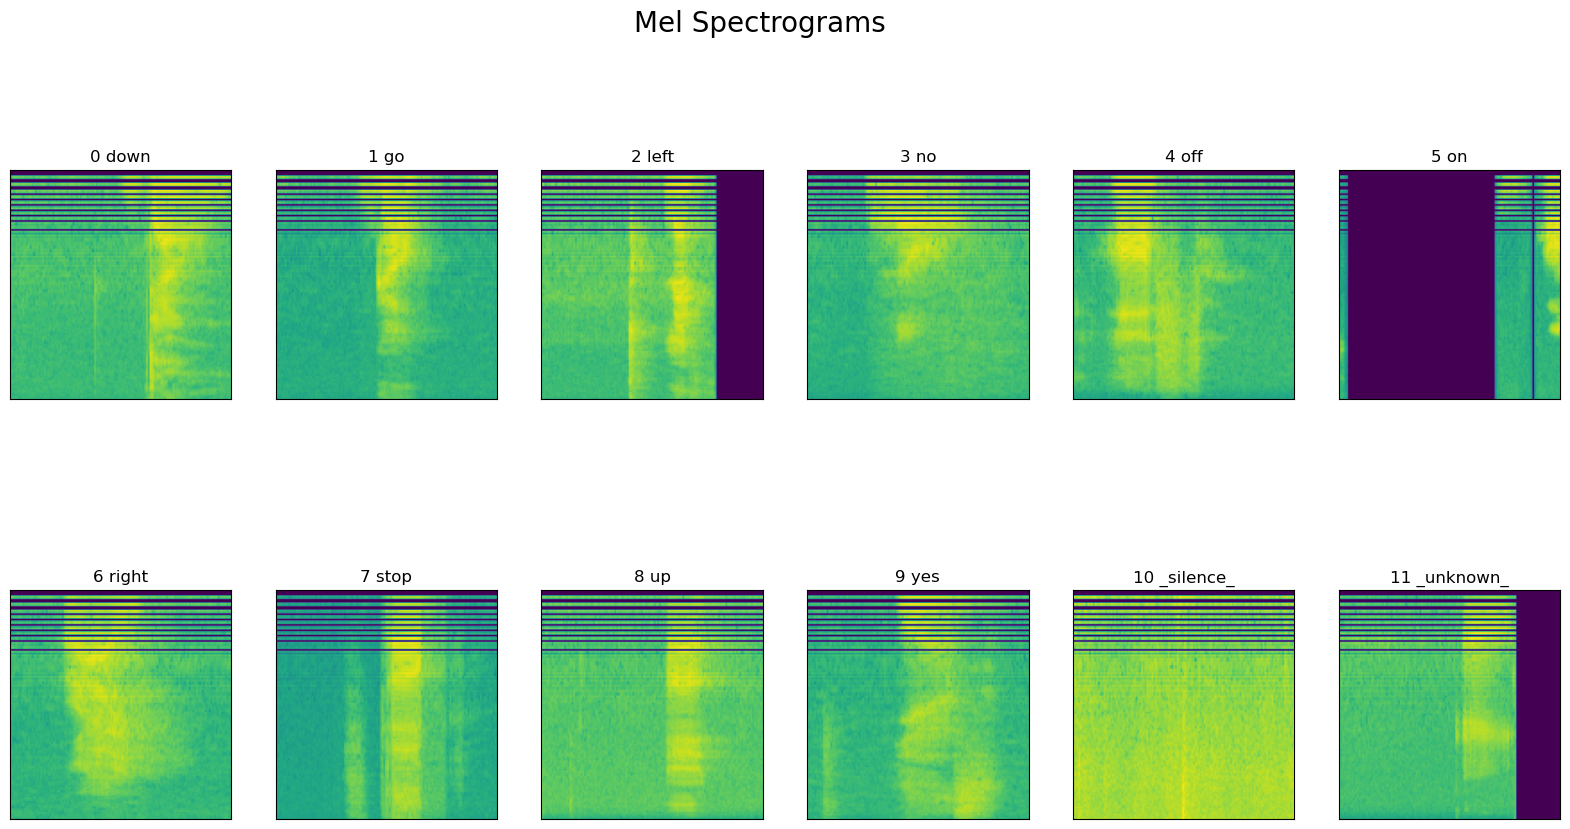

In [102]:
plot_spectrogram(titles, mel_spectrograms, 'Mel Spectrograms')